# Updated ABA rate prediction model

* Original model with Vienna value and base change representation has r value of ~.887 (r^2 .786)
* ^Model including all Vienna and Mfold information has an r value of ~.894 (r^2 of .799)
* ^Model with pooling features has an r value of .919 (r^2 of .844). Test accuracy r of .900 (r^2 of .810)
* ^Deep learning model with all of the above variables has a training r value of .958 (r^2 of .917) with lower performance test (holdout data) r value of .930 (r^2 of .865)

In [45]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl
#make sure to install keras if you don't have the package yet
from keras import layers, models

## Original Model

**All if not most of the next cell is code from the last notebook**

In [77]:
# Time to load in the data
data2 = pd.read_csv("data7.csv")
energies2 = pd.read_csv("subopt_attributes7.csv")
energies2["sequence"] = energies2.Sequence.str.slice(29, -32).str.replace("U", "T")
windows2 = pd.read_csv("vienna_windows7.csv")
windows2["sequence"] = windows2['0'].str.slice(29, -32).str.replace("U", "T")
big_table2 = pd.merge(energies2, data2, on='sequence', how="inner")
big_table2 = pd.merge(big_table2, windows2, on='sequence', how="inner")
#big_table = data
#columns list needed when we add data later
cols2 = list(energies2.columns)
cols2.remove('Sequence')
cols2.remove('sequence')



#now we want to add the ABA column to big_table
perfect_sequence2 = "TTTGATCTGAAATATTCAGGTC"
PERFECT_KD2 = big_table2[big_table2['sequence'] == perfect_sequence2].iloc[0]['kd']
#PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table2['ABA'] = (big_table2.kd/PERFECT_KD2).apply(np.log)
big_table2.head()

##########################
#other table
#########################
# Time to load in the data
data1 = pd.read_csv("data4.csv")
energies1 = pd.read_csv("subopt_attributes4.csv")
energies1 = energies1.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
                          'mfold_skew','mfold_median'], axis=1)
energies1["sequence"] = energies1.Sequence.str.slice(29, -32).str.replace("U", "T")
windows1 = pd.read_csv("vienna_windows4.csv")
windows1["sequence"] = windows1['0'].str.slice(29, -32).str.replace("U", "T")
big_table1 = pd.merge(energies1, data1, on='sequence', how="inner")
big_table1 = pd.merge(big_table1, windows1, on='sequence', how="inner")

#columns list needed when we add data later
cols1 = list(energies1.columns)
cols1.remove('Sequence')
cols1.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence1 = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['kd']
PERFECT_SEQ1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['Sequence']
big_table1['ABA'] = (big_table1.kd/PERFECT_KD1).apply(np.log)
big_table1.head()

#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(int(30/1.5),int(15/1.5)),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title)
    plt.show()

def display2(predicted, actual, title="predicted vs actual"):
    plt.figure(figsize=(6, 6))
    plt.hexbin(predicted, actual, edgecolors='none', gridsize=75,cmap='viridis',mincnt=1)
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title,size=16)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y


def create_matrix_0(randomize=True):
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            #coords = get_diff(perfect_sequence, seq)
            #if len(coords) > 5:
            #    pass
            #else:
            row = [0 for i in range(4*max_len)]
            for i in range(len(seq)):
                if seq[i] == 'A':
                    row[i*4 + 0] = 1
                elif seq[i] == 'C':
                    row[i*4 + 1] = 1
                elif seq[i] == 'G':
                    row[i*4 + 2] = 1
                elif seq[i] == 'T':
                    row[i*4 + 3] = 1
                else:
                    print("Impossible happened check seq values", seq)
                #row[get_position(coord)] = 1
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            pruned_combined_data_matrix.append(row)
            pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    if randomize:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    return X, y

def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

def create_matrix2(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                print(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])

    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

# the start of this function is same as before
def create_matrix3(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
# the start of this function is same as before
def create_matrix4(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        
        row = [0 for i in range(4*max_len)]
        for i in range(len(seq)):
            if seq[i] == 'A':
                row[i*4 + 0] = 1
            elif seq[i] == 'C':
                row[i*4 + 1] = 1
            elif seq[i] == 'G':
                row[i*4 + 2] = 1
            elif seq[i] == 'T':
                row[i*4 + 3] = 1
            else:
                print("Impossible happened check seq values", seq)
        #add_row.extend(row) big change to not include absolute representation
        X_add.append(add_row)
        
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    #X = np.append(X, create_matrix_0(randomize=False)[0], axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    y = preprocessing.scale(y)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

# incorporating the aba

In [4]:
structures = pd.read_csv("vienna_structures.csv")
data = pd.read_csv("data4.csv")
structures["sequence"] = structures.Sequence.str.slice(29, -32).str.replace("U", "T")
structures["micro_structure"] = structures.Structure.str.slice(29,-32)
table = pd.merge(data, structures, on='sequence', how="inner")

In [5]:
#now we want to add the ABA column to big_table
perfect_sequence = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD = table[table['sequence'] == perfect_sequence1].iloc[0]['kd']
PERFECT_SEQ = table[table['sequence'] == perfect_sequence1].iloc[0]['Sequence']
table['ABA'] = (table.kd/PERFECT_KD1).apply(np.log)
table.head()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count,Sequence,ViennaEnergy (kcal/mol),Structure,micro_structure,ABA
0,CCATAGAGAGGTTTAGGCGACA,0.411732,0.077708,0.000001,69772.0,56,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUUAGG...,-17.200001,.((.((((((.(........).)))))).)).....(.((((((((...,)).....(.((((((((((...,-1.890462
1,CCATAAATAGGTTATCCGCTCA,50.996896,5.568243,31137.437284,69772.0,56,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAAAUAGGUUAUCC...,-16.200001,((((.(((((((.....((((....)))).........))..))))...,.........))..))))).)).,2.928686
2,CCATAGAAGGTTATCCGCTA,50.162063,4.509536,33937.023904,69772.0,59,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAAGGUUAUCCG...,-15.800000,((...(((((...(.((((((....))).....))).)...)))))...,....))).)...)))))...,2.912180
3,CCATAAGAGAGGTTAGTCCGCTCA,11.020798,1.343522,26403.072224,69772.0,69,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAAGAGAGGUUAGU...,-18.200001,((((.(((((..((.((((((....)))........))).))..))...,.......))).))..))))).)).,1.396706
4,CCATAGAAGGTTATCCGCTC,139.873453,11.447599,29946.137330,69772.0,88,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAAGGUUAUCCG...,-21.299999,((((.(((((...(.((((((....))).....))).)...)))))...,....))).)...))))).)),3.937660


In [6]:
max_len = max([len(elt) for elt in table.micro_structure])
print(max_len, "max_len")
X = []
y = []
for i, row in table.iterrows():
    #print(row['count'])
    if row['kd'] > 1:
        x = []
        for i in range(max_len):
            if i < len(row['micro_structure']):
                if row['micro_structure'][i] == ".":
                    x.append(0)
                else:
                    x.append(1)
            else:
                x.append(0)
        y.append(row['ABA'])
        X.append(x)
X = np.array(X)
y = np.array(y)

24 max_len


In [7]:
data.head()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count
0,CCATAGAGAGGTTTAGGCGACA,0.411732,0.077708,0.000001,69772.0,56
1,CCATAAATAGGTTATCCGCTCA,50.996896,5.568243,31137.437284,69772.0,56
2,CCATAGAAGGTTATCCGCTA,50.162063,4.509536,33937.023904,69772.0,59
3,CCATAAGAGAGGTTAGTCCGCTCA,11.020798,1.343522,26403.072224,69772.0,69
4,CCATAGAAGGTTATCCGCTC,139.873453,11.447599,29946.137330,69772.0,88


In [8]:
structures.head()

,Sequence,ViennaEnergy (kcal/mol),Structure,sequence,micro_structure
0,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUAC...,-15.7,.((.((((((.(........).)))))).)).....(((.(((.((...,CCATAGAGAGGTTATACACGCTCA,)).....(((.(((.((..((((.
1,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAGAGAGUGGUUAUCC...,-23.6,((((.(((((((((.((((((....)))...)))..))))..))))...,CCAGAGAGTGGTTATCCGCTCA,..)))..))))..))))).)).
2,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-20.9,((((.(((((((.((((((((....))).....))))).))..)))...,CCATAGATGAGGTTATCCGCGTCA,....))))).))..)))))..)).
3,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGACGGUGUAU...,-22.5,.((.((((((.(........).)))))).))....(((((((((.(...,CCATAGAGACGGTGTATCCGCTCA,))....(((((((((.((((.((.
4,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-22.4,((((((((((((...((((((....))).....)))..))..))))...,CCATAGAGAGGTTATCCGTTCT,....)))..))..)))))))).


In [9]:
table.head()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count,Sequence,ViennaEnergy (kcal/mol),Structure,micro_structure,ABA
0,CCATAGAGAGGTTTAGGCGACA,0.411732,0.077708,0.000001,69772.0,56,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUUAGG...,-17.200001,.((.((((((.(........).)))))).)).....(.((((((((...,)).....(.((((((((((...,-1.890462
1,CCATAAATAGGTTATCCGCTCA,50.996896,5.568243,31137.437284,69772.0,56,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAAAUAGGUUAUCC...,-16.200001,((((.(((((((.....((((....)))).........))..))))...,.........))..))))).)).,2.928686
2,CCATAGAAGGTTATCCGCTA,50.162063,4.509536,33937.023904,69772.0,59,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAAGGUUAUCCG...,-15.800000,((...(((((...(.((((((....))).....))).)...)))))...,....))).)...)))))...,2.912180
3,CCATAAGAGAGGTTAGTCCGCTCA,11.020798,1.343522,26403.072224,69772.0,69,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAAGAGAGGUUAGU...,-18.200001,((((.(((((..((.((((((....)))........))).))..))...,.......))).))..))))).)).,1.396706
4,CCATAGAAGGTTATCCGCTC,139.873453,11.447599,29946.137330,69772.0,88,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAAGGUUAUCCG...,-21.299999,((((.(((((...(.((((((....))).....))).)...)))))...,....))).)...))))).)),3.937660


In [10]:
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1)

In [11]:
reg.score(X,y)

0.25543446093587585

In [12]:
predicted_output = X @ reg.coef_ + reg.intercept_

In [13]:
corr, p_value = pearsonr(predicted_output, y)

In [14]:
corr

0.5054057029473022

(array([122.,  84., 108., 152., 162., 167., 175., 260., 245., 307., 280.,
        347., 349., 360., 354., 268., 234., 192., 142., 125., 106.,  68.,
         37.,  22.,   6.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([-1.00306772, -0.72125787, -0.43944802, -0.15763817,  0.12417168,
         0.40598153,  0.68779139,  0.96960124,  1.25141109,  1.53322094,
         1.81503079,  2.09684064,  2.3786505 ,  2.66046035,  2.9422702 ,
         3.22408005,  3.5058899 ,  3.78769975,  4.06950961,  4.35131946,
         4.63312931,  4.91493916,  5.19674901,  5.47855886,  5.76036872,
         6.04217857,  6.32398842,  6.60579827,  6.88760812,  7.16941797,
         7.45122782,  7.73303768,  8.01484753,  8.29665738,  8.57846723,
         8.86027708,  9.14208693,  9.42389679,  9.70570664,  9.98751649,
      

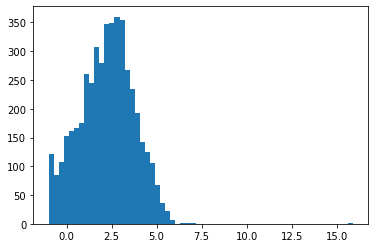

In [15]:
plt.hist(y, bins=60)

In [16]:
filter_y = []
for i in range(len(X)):
    if sum(X[i][:8]) >= 8:
        filter_y.append(y[i])

(array([1., 0., 0., 0., 1., 1., 3., 5., 9., 2.]),
 array([0.31082516, 0.84513573, 1.3794463 , 1.91375687, 2.44806744,
        2.98237801, 3.51668857, 4.05099914, 4.58530971, 5.11962028,
        5.65393085]),
 <BarContainer object of 10 artists>)

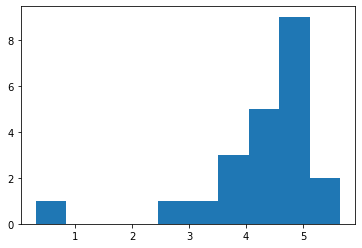

In [17]:
plt.hist(filter_y)

In [81]:
def create_filtered(X,y, boundary, cutoff=8, reverse=False):
    filter_y = []
    if not reverse:
        for i in range(len(X)):
            if sum(X[i][:cutoff]) >= boundary:
                filter_y.append(y[i])
    else:
        for i in range(len(X)):
            if sum(X[i][-cutoff:]) >= boundary:
                filter_y.append(y[i])
    return np.array(filter_y)
def create_filtered_equal(X,y, boundary, cutoff=8, reverse=False):
    filter_y = []
    if not reverse:
        for i in range(len(X)):
            if sum(X[i][:cutoff]) == boundary:
                filter_y.append(y[i])
    else:
        for i in range(len(X)):
            if sum(X[i][-cutoff:]) == boundary:
                filter_y.append(y[i])
    return np.array(filter_y)

In [97]:
average_aba = []
counts = []
for i in range(9):
    arr = -create_filtered_equal(X,y,i)
    average_aba.append(np.median(arr))
    counts.append(len(arr))

In [95]:
create_filtered_equal(X,y,0).mean()

3.996832316100548

Text(0.5, 0, 'Minimal Number of BPs')

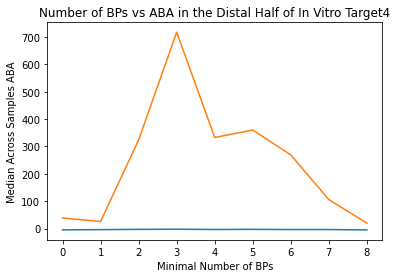

In [98]:
plt.plot(average_aba, label="median")
plt.plot(counts, label="counts")
plt.title("Number of BPs vs ABA in the Distal Half of In Vitro Target4")
plt.ylabel("Median Across Samples ABA")
plt.xlabel("Minimal Number of BPs")

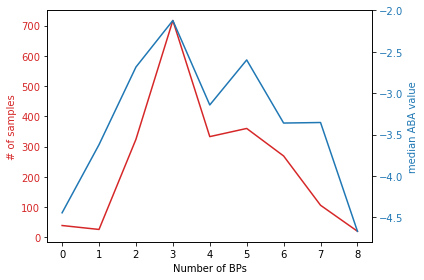

In [101]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of BPs')
ax1.set_ylabel('# of samples', color=color)
ax1.plot(counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('median ABA value', color=color)  # we already handled the x-label with ax1
ax2.plot(average_aba, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

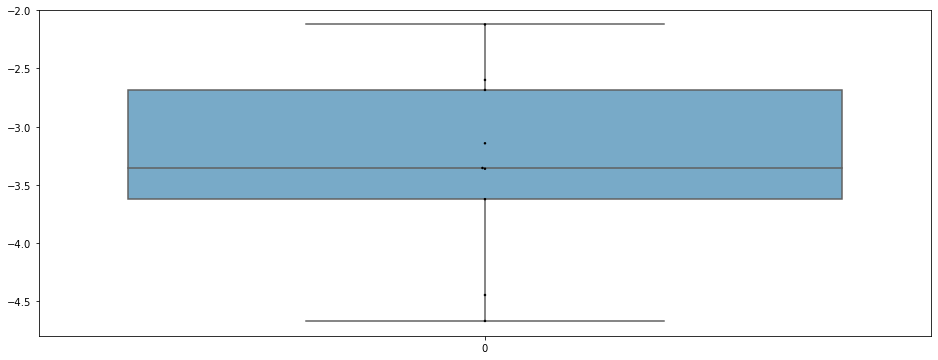

In [107]:
#Box plot for basepairing analysis
fig, ax = plt.subplots(1,1,figsize=(16,6))
xticks = ['0','1','2','3','4','5','6','>6']

#seaborn boxplot
#data here is list of lists, data = [[distal bps(from 0 to >6)],[proximal bps(from 0 to >6)]]
sns.boxplot(data=[average_aba],ax=ax,palette="Blues", showfliers=False)

#Plot scatter dots on the boxplot
sns.swarmplot(data=[average_aba],ax=ax,color='k',size=2.5, edgecolor=None)

#ax.set_xticklabels(xticks)
#ax1.set_xticklabels(xticks)
#ax.set_ylabel('$\Delta$ABA ($K_bT$)')
#ax.set_xlabel('Base pairing counts (position 12-22)')
#ax1.set_xlabel('Base pairing counts (position 1-11)')
plt.tight_layout

<AxesSubplot:xlabel='# of BPs', ylabel='aba'>

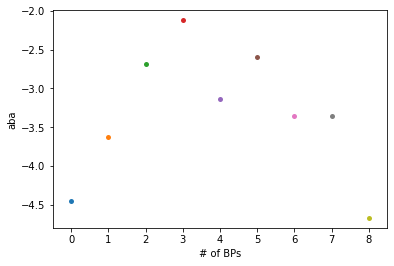

In [114]:
x = pd.DataFrame(average_aba, columns=['aba'])
x['# of BPs'] = x.index
sns.swarmplot(x='# of BPs', y="aba", data=x)

Text(0.5, 1.0, 'ABA vs # of BP in Proximal Region')

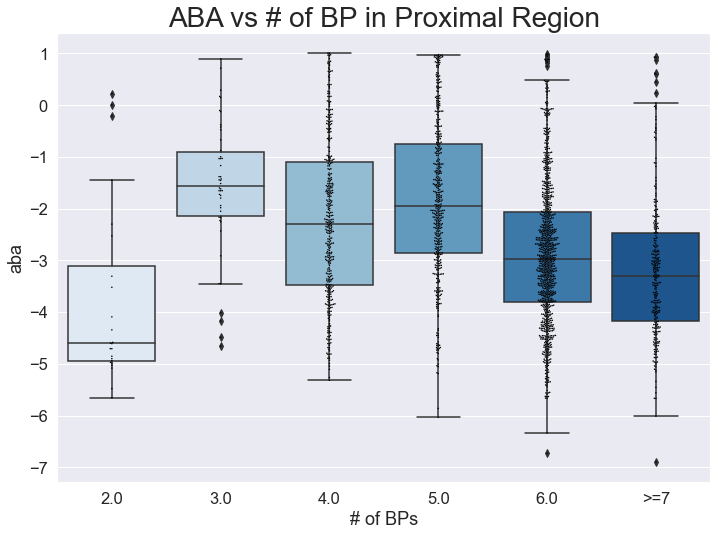

In [163]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":28,"axes.labelsize":18})
sns.set_style("ticks")
sns.set(font_scale = 1.5)
x = pd.DataFrame(columns=['aba', '# of BPs'])
for i in range(7):
    arr = -create_filtered_equal(X,y,i, reverse=True)
    for elt in arr:
        x = x.append({'aba':elt, '# of BPs':i}, ignore_index=True)
arr = -create_filtered(X,y,7, reverse=True)
for elt in arr:
    x = x.append({'aba':elt, '# of BPs':">=7"}, ignore_index=True)
sns.swarmplot(x='# of BPs', y="aba", data=x, size=1.5, color="black")
sns.boxplot(x="# of BPs", y="aba", data=x, palette="Blues")
plt.title("ABA vs # of BP in Proximal Region", fontsize=28)

## Plot distal median vs proximal median

Text(0, 0.5, 'Median ABA')

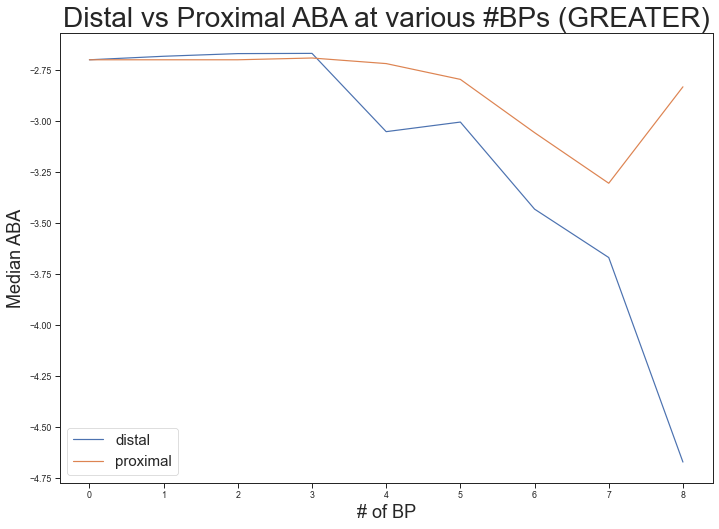

In [152]:
distal = []
prox = []
for i in range(9):
    arr = -create_filtered(X,y,i)
    distal.append(np.median(arr))
    arr = -create_filtered(X,y,i, reverse=True)
    prox.append(np.median(arr))
plt.plot(distal, label="distal")
plt.plot(prox, label="proximal")
plt.legend(prop={'size': 15})
plt.title("Distal vs Proximal ABA at various #BPs (GREATER)")
plt.xlabel("# of BP")
plt.ylabel("Median ABA")

In [119]:
x

,aba,# of BPs


In [109]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


(22.0, -1.0, -1.5, 0.8)

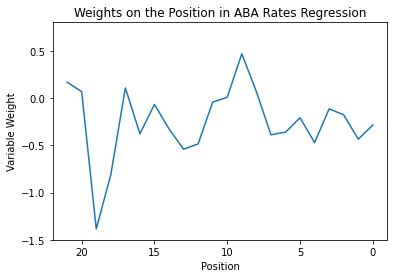

In [60]:
plt.plot(range(len(reg.coef_))[::-1],-reg.coef_)
plt.title("Weights on the Position in ABA Rates Regression")
plt.xlabel("Position")
plt.ylabel("Variable Weight")
plt.axis([22,-1,-1.5,.8])

In [27]:
max_len = len(perfect_sequence)
print(max_len, "max_len")
X = []
y = []
for i, row in table.iterrows():
    #print(row['count'])
    if row['kd'] > 1 and len(row['micro_structure']) == len(perfect_sequence):
        x = []
        for i in range(max_len):
            if i < len(row['micro_structure']):
                if row['micro_structure'][i] == ".":
                    x.append(0)
                else:
                    x.append(1)
            else:
                x.append(0)
        y.append(row['ABA'])
        X.append(x)
X = np.array(X)
y = np.array(y)

22 max_len


In [28]:
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1)

In [29]:
print("r^2 is", reg.score(X,y))
predicted_output = X @ reg.coef_ + reg.intercept_
corr, p_value = pearsonr(predicted_output, y)
print("correlation is", corr)

r^2 is 0.29254332065897426
correlation is 0.5408752145875038


Text(0.5, 0, 'Minimal Number of BPs')

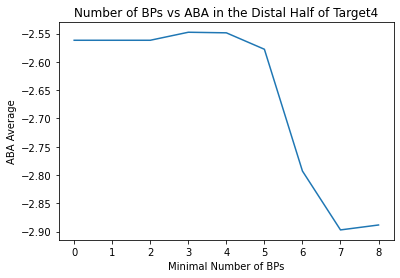

In [64]:
average_aba = []
for i in range(9):
    average_aba.append(-create_filtered(X,y,i, cutoff=10, reverse=True).mean())
plt.plot(average_aba)
plt.title("Number of BPs vs ABA in the Distal Half of Target4")
plt.ylabel("ABA Average")
plt.xlabel("Minimal Number of BPs")

(22.0, -1.0, -0.8, 1.5)

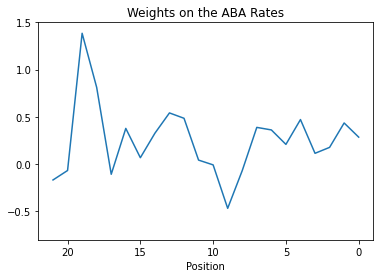

In [103]:
plt.plot(range(len(reg.coef_))[::-1],reg.coef_)
plt.title("Weights on the ABA Rates")
plt.xlabel("Position")
plt.axis([22,-1,-.8,1.5])

Text(0.5, 0, 'Number of BP')

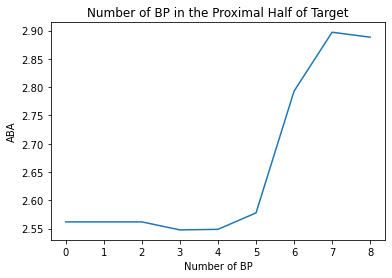

In [80]:
average_aba = []
for i in range(9):
    average_aba.append(create_filtered(X,y,i,cutoff=10, reverse=True).mean())
plt.plot(average_aba)
plt.title("Number of BP in the Proximal Half of Target")
plt.ylabel("ABA")
plt.xlabel("Number of BP")

Text(0.5, 0, 'Number of Bounds')

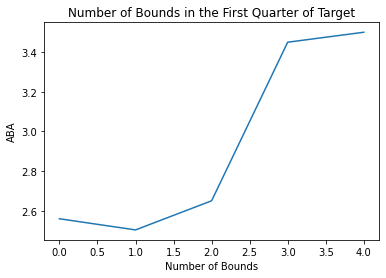

In [112]:
average_aba = []
for i in range(5):
    average_aba.append(create_filtered(X,y,i,cutoff=5).mean())
plt.plot(average_aba)
plt.title("Number of Bounds in the First Quarter of Target")
plt.ylabel("ABA")
plt.xlabel("Number of Bounds")

(array([ 38.,  19.,  15.,  19.,  25.,  22.,  38.,  35.,  29.,  42.,  31.,
         27.,  42.,  52.,  38.,  55.,  67.,  65.,  58.,  80.,  80.,  95.,
         83.,  90.,  94., 103.,  85.,  86.,  80.,  86.,  80.,  56.,  48.,
         62.,  58.,  55.,  50.,  37.,  22.,  13.,  13.,   8.,   7.,   1.,
          2.,   0.,   1.,   0.,   1.,   1.]),
 array([-1.00306772, -0.84509338, -0.68711903, -0.52914468, -0.37117033,
        -0.21319599, -0.05522164,  0.10275271,  0.26072705,  0.4187014 ,
         0.57667575,  0.73465009,  0.89262444,  1.05059879,  1.20857314,
         1.36654748,  1.52452183,  1.68249618,  1.84047052,  1.99844487,
         2.15641922,  2.31439356,  2.47236791,  2.63034226,  2.78831661,
         2.94629095,  3.1042653 ,  3.26223965,  3.42021399,  3.57818834,
         3.73616269,  3.89413704,  4.05211138,  4.21008573,  4.36806008,
         4.52603442,  4.68400877,  4.84198312,  4.99995746,  5.15793181,
         5.31590616,  5.47388051,  5.63185485,  5.7898292 ,  5.94780355,
 

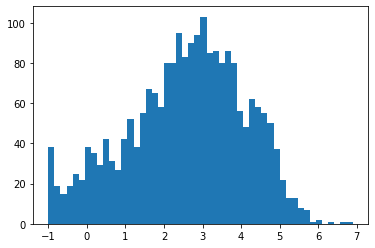

In [115]:
plt.hist(create_filtered(X,y,0,cutoff=5), bins=50)

(array([ 1.,  1.,  2.,  2.,  1.,  2.,  1.,  0.,  2.,  2.,  1.,  0.,  4.,
         3.,  4.,  9.,  7.,  9.,  7., 12., 11.,  7., 13.,  9., 11.,  8.,
        15., 16., 10., 11., 18.,  8., 10., 21., 11., 15., 20., 17., 13.,
         8.,  7.,  8.,  3.,  1.,  2.,  0.,  1.,  0.,  1.,  1.]),
 array([-0.89358251, -0.73779787, -0.58201323, -0.42622858, -0.27044394,
        -0.1146593 ,  0.04112534,  0.19690999,  0.35269463,  0.50847927,
         0.66426392,  0.82004856,  0.9758332 ,  1.13161784,  1.28740249,
         1.44318713,  1.59897177,  1.75475642,  1.91054106,  2.0663257 ,
         2.22211034,  2.37789499,  2.53367963,  2.68946427,  2.84524892,
         3.00103356,  3.1568182 ,  3.31260284,  3.46838749,  3.62417213,
         3.77995677,  3.93574142,  4.09152606,  4.2473107 ,  4.40309534,
         4.55887999,  4.71466463,  4.87044927,  5.02623391,  5.18201856,
         5.3378032 ,  5.49358784,  5.64937249,  5.80515713,  5.96094177,
         6.11672641,  6.27251106,  6.4282957 ,  6.58408034,

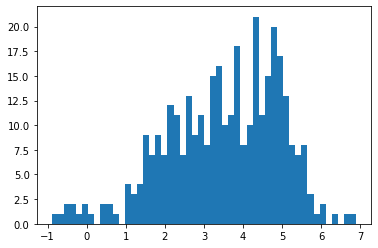

In [116]:
plt.hist(create_filtered(X,y,4,cutoff=5), bins=50)

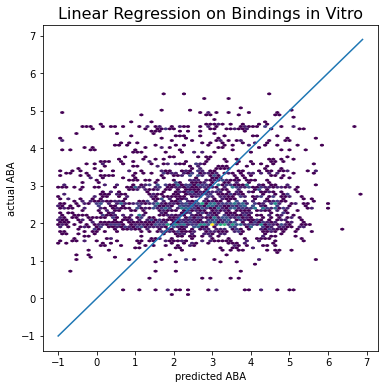

In [78]:
display2(y, predicted_output, title="Linear Regression on Bindings in Vitro")

In [52]:
#returns a CNN model given training data
def train(X, y, batch_size=100, epochs=100):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    print("input shaped", (len(X[0]), 1, 1))
    
    model = models.Sequential()
    #model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(32, (5, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    #model.add(layers.Conv2D(64, (10, 1), activation='relu'))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    

    #model.compile(loss='mean_squared_error',
    #              optimizer='sgd')
    model.compile(loss='logcosh',
                  optimizer='sgd')
    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

#fits the data based on the trained model from above
def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    display(model.predict(X_).reshape(len(X_)), y, title="CNN on Bindings in Vitro")
    
    corr, p_value = pearsonr((model.predict(X_).reshape(len(X_))), y)
    print("corr is", corr)
    #return vhinge((model.predict(X_)).reshape(len(X_))), y
    
# no longer necessary  
def without_outliers(model, X, y):
    outliers = []
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    predictions = vhinge((model.predict(X_)).reshape(len(X_)))
    for i in range(len(predictions)):
        if predictions[i]-y[i] > 3:
            print("removing", predictions[i], y[i])
            predictions = np.delete(predictions, i)
            y.pop(i)

In [43]:
len(X)

2194

input shaped (22, 1, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 1, 32)         192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                3088      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 2ms/step - loss: 2.0259
Epoch 2/500
16

16/16 [==============================] - 0s 2ms/step - loss: 0.4669
Epoch 190/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4656
Epoch 191/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4585
Epoch 192/500
16/16 [==============================] - 0s 1ms/step - loss: 0.4540
Epoch 193/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4554
Epoch 194/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4705
Epoch 195/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4656
Epoch 196/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4619
Epoch 197/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4671
Epoch 198/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4648
Epoch 199/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4527
Epoch 200/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4369
Epoch 201/500
16/16 [=========

16/16 [==============================] - 0s 3ms/step - loss: 0.4257
Epoch 290/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4382
Epoch 291/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4396
Epoch 292/500
16/16 [==============================] - 0s 5ms/step - loss: 0.4123
Epoch 293/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4209
Epoch 294/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4174
Epoch 295/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4175
Epoch 296/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4197
Epoch 297/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4283
Epoch 298/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4438
Epoch 299/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4416
Epoch 300/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4500
Epoch 301/500
16/16 [=========

16/16 [==============================] - 0s 2ms/step - loss: 0.4016
Epoch 390/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4005
Epoch 391/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4148
Epoch 392/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4195
Epoch 393/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4302
Epoch 394/500
16/16 [==============================] - 0s 3ms/step - loss: 0.4181
Epoch 395/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4164
Epoch 396/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4334
Epoch 397/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4211
Epoch 398/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4102
Epoch 399/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4075
Epoch 400/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4165
Epoch 401/500
16/16 [=========

16/16 [==============================] - 0s 2ms/step - loss: 0.3997
Epoch 490/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4040
Epoch 491/500
16/16 [==============================] - 0s 2ms/step - loss: 0.3904
Epoch 492/500
16/16 [==============================] - 0s 2ms/step - loss: 0.3818
Epoch 493/500
16/16 [==============================] - 0s 2ms/step - loss: 0.3976
Epoch 494/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4094
Epoch 495/500
16/16 [==============================] - 0s 2ms/step - loss: 0.3975
Epoch 496/500
16/16 [==============================] - 0s 1ms/step - loss: 0.4029
Epoch 497/500
16/16 [==============================] - 0s 1ms/step - loss: 0.3933
Epoch 498/500
16/16 [==============================] - 0s 1ms/step - loss: 0.4136
Epoch 499/500
16/16 [==============================] - 0s 1ms/step - loss: 0.3964
Epoch 500/500
16/16 [==============================] - 0s 2ms/step - loss: 0.4082


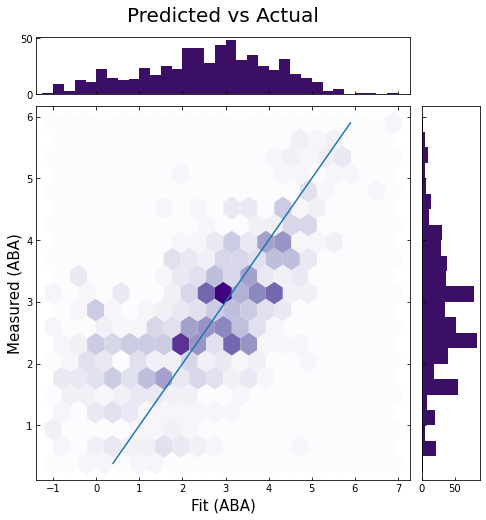

corr is 0.6710254263097235


In [49]:
cutoff = 1600
X, y = shuffle(X, y)
#this will take 5 minutes to run
X_train = X[:cutoff]
X_test = X[cutoff:]

y_train = y[:cutoff]
y_test = y[cutoff:]

model = train(X_train, y_train, epochs=500)
fit(model, X_test, y_test)

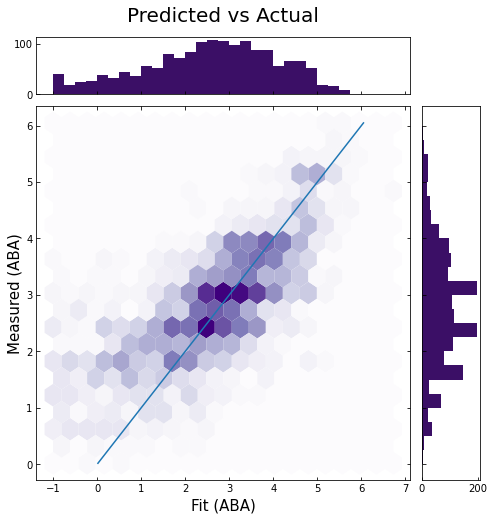

corr is 0.7206936022829629


In [50]:
fit(model, X_train, y_train)

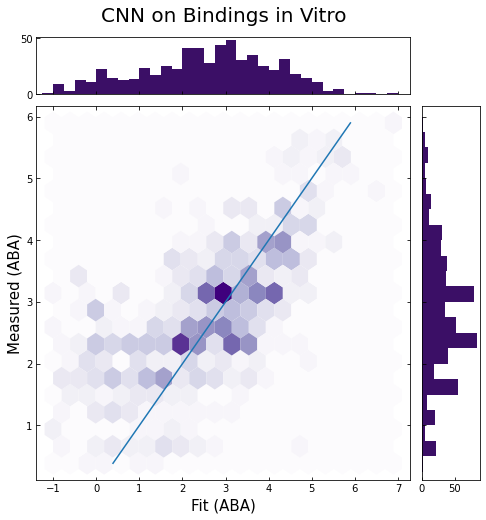

corr is 0.6710254263097235


In [53]:
fit(model, X_test, y_test)